# Decision Tree Regression Analysis of House Prices 

## Import the Libraries 

In [620]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import make_scorer, mean_squared_error

## Import and Clean the Data 

In [621]:
#Data is imported, "Year_Built" is parsed from an integer to a date time object 
housing = pd.read_csv("real_estate_data.csv", parse_dates = ["Year_Built"], date_format = "%m/%d/%Y")
housing

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.8167
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.1354
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.6969
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.6560
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.1425
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,138.338057,2,2,2,1967,1,0,16,4.296086,5.562583,488496.3507
496,497,195.914028,2,3,1,1977,0,1,45,7.406261,2.845105,657736.9217
497,498,69.433659,1,1,2,2004,0,0,18,8.629724,6.263264,405324.9502
498,499,293.598702,5,1,3,1940,1,0,41,5.318891,16.990684,773035.9680


In [622]:
#'ID' column is dropped, other columns are renamed for readability
#'Garden?' and 'Pool?' columns are converted to categorical variables for more efficient memory usage

housing = housing.drop(columns = ["ID"])
housing = housing.rename(columns = {"Square_Feet":"Property Size (square meters)","Num_Bedrooms":"Bedrooms","Num_Bathrooms":"Bathrooms","Num_Floors":"Floors",
                         "Year_Built":"Year Built","Has_Garden":"Garden?","Has_Pool":"Pool?","Garage_Size":"Garage Size (square meters)",
                         "Location_Score":"Location Quality Score", "Distance_to_Center":"Distance to City (km)"})
housing["Garden?"] = housing["Garden?"].astype("category")
housing["Pool?"] = housing["Pool?"].astype("category")

housing.head(10)

,Property Size (square meters),Bedrooms,Bathrooms,Floors,Year Built,Garden?,Pool?,Garage Size (square meters),Location Quality Score,Distance to City (km),Price
0,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.8167
1,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.1354
2,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.6969
3,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.6560
4,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.1425
5,88.998630,5,3,2,1959,1,1,36,8.994552,17.633250,670386.8044
6,64.520903,4,3,1,1938,0,1,32,7.101354,2.429908,523827.1256
7,266.544036,5,1,3,1973,1,1,39,9.373784,12.692785,875352.5452
8,200.278753,5,1,1,1988,1,1,32,6.032918,11.642876,738269.8523
9,227.018144,3,2,1,1917,0,0,29,4.734009,2.368301,490552.6812


In [623]:
#'Garage Size is measured in square meters
#'Distance to City' is measured in kilometers 
#'Location Quality Score' is measured from 1 to 10 with higher numbers representing more desirable locations 
#The Data contains no null values 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Property Size (square meters)  500 non-null    float64 
 1   Bedrooms                       500 non-null    int64   
 2   Bathrooms                      500 non-null    int64   
 3   Floors                         500 non-null    int64   
 4   Year Built                     500 non-null    object  
 5   Garden?                        500 non-null    category
 6   Pool?                          500 non-null    category
 7   Garage Size (square meters)    500 non-null    int64   
 8   Location Quality Score         500 non-null    float64 
 9   Distance to City (km)          500 non-null    float64 
 10  Price                          500 non-null    float64 
dtypes: category(2), float64(4), int64(4), object(1)
memory usage: 36.5+ KB


## Split Data into Independent Feature Matrix (x) and Dependent Variable (y)

In [624]:
#data is split into a matrix of independent variables and a single dependent variable 
#Feature scaling is not required for decision tree regression
x = housing.iloc[:,:-1].values
y = housing.iloc[:,-1].values 

## Split Data into Test and Train Subsets

In [625]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 1701)

## Instantiate and Train the Decision Tree Regression Model

In [626]:
#Decision tree model is instantiated
dt_regressor = DecisionTreeRegressor(random_state = 1701)

#A range of max_depth values is defined for testing and hyperparameter tuning  
grid_parameters = {"max_depth":range(1,25)}

#Model performance will be judged via mean squared error (MSE)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

#a GridSearchCV object is instantiated for cross validation testing/hyperparameter tuning 
grid_search = GridSearchCV(estimator=dt_regressor,
                           param_grid=grid_parameters,
                           scoring=scorer,  
                           cv=12)            

grid_search.fit(x_train, y_train)


print("Optimal max_depth:", grid_search.best_params_['max_depth'])
print("Best Score (MSE):", -grid_search.best_score_)

#The decision tree regression object is instantiated again using the optimal max_depth, determined by grid_search
#The Optimal max depth is determined to be 5. 
#This represents the optimal balance between overfitting and keeping the model generalizable
dt_regressor = DecisionTreeRegressor(max_depth=grid_search.best_params_['max_depth'], random_state=1701)
dt_regressor.fit(x_train,y_train)


Optimal max_depth: 5
Best Score (MSE): 5054467521.710057


DecisionTreeRegressor(max_depth=5, random_state=1701)

## Visualize Hierarchical Structure of Decision Tree

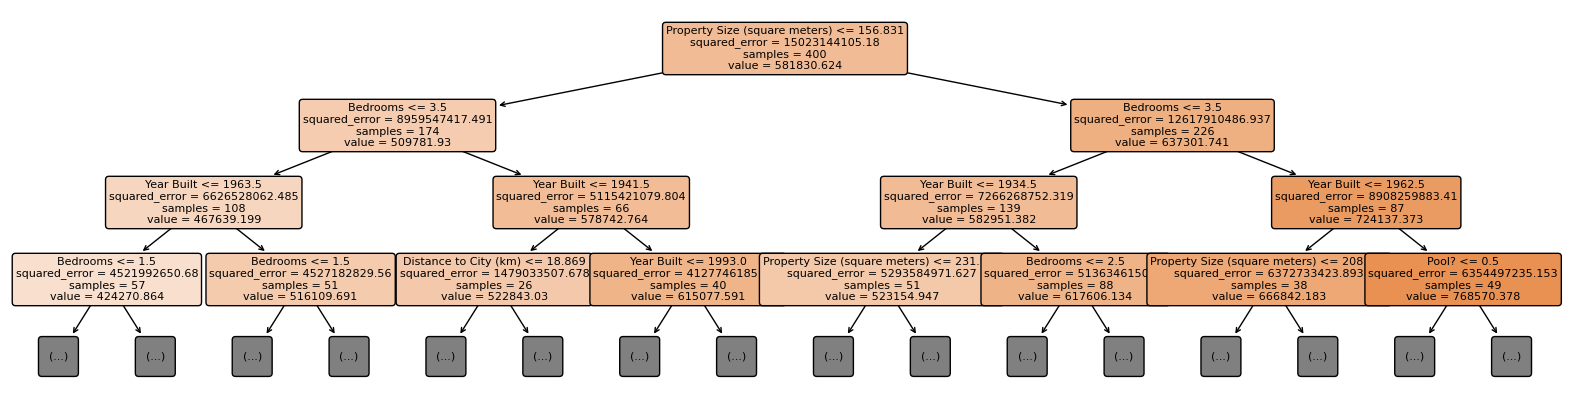

In [627]:
#The plot_tree() method is used to display the decision tree's nodes and decision points
#Darker colored nodes represent higher predicted values of house prices
#Tree visualization is confined to a depth of 3 for readability 
feature_labels = list(housing.iloc[:,:-1].columns)

plt.figure(figsize = (20,5))
plot_tree(dt_regressor, 
          feature_names = feature_labels, 
          filled= True, 
          rounded = True, 
          fontsize = 8,
          max_depth = 3)
plt.show()

## Evaluate the Relative Importance of Each Independent Variable

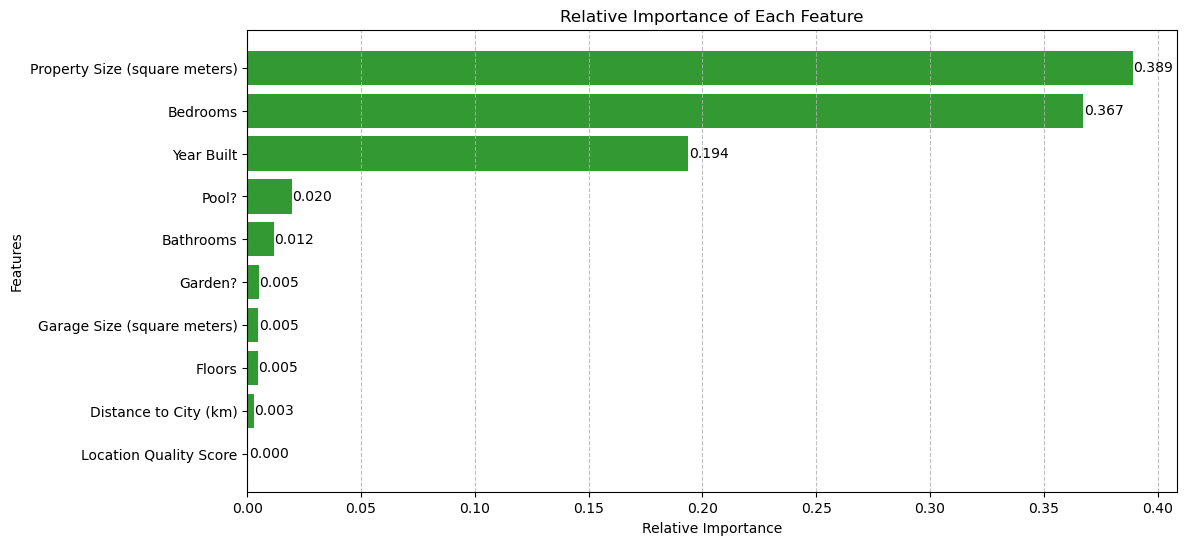

In [628]:
#The variable 'relative_importances' stores a numpy array containing the relative importance of each feature in terms of making predictions. 
#"Importance" is calculated by the degree to which a variable decreases variance in the target variable when data is split within a node. 
#Larger decreases in variance result in higher importance scores, the overall importance score is an average of scores for that variable across all nodes
relative_importances = dt_regressor.feature_importances_

#A numpy array of indices is generated, sorting the indices of 'relative_importances' in ascending order of their associated importance scores
importance_indices = np.argsort(relative_importances)

#Feature labels are sorted to match the order of their corresponding importance scores 
sorted_labels = [feature_labels[i] for i in importance_indices]

#The relative importance of each feature is visualized in a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.grid(axis='x', linestyle='--', alpha=0.8)
bars = plt.barh(sorted_labels, relative_importances[importance_indices], color='green', alpha = 0.8)
for bar in bars:
    if bar.get_width() == 0:
        distance = 0.001
    else:
        distance = 0.0001
    plt.text(
        bar.get_width() + distance,  # Positions value slightly to the right of the bar 
        bar.get_y() + bar.get_height() / 2,  # Centers the value vertically in the middle of the bar's height
        f'{bar.get_width():.3f}',  # bar width is formated in an f-string and rounded to 3 decimal places 
        va='center'  
    )
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature')
plt.show()

## Evaluate the Percent Accuracy of Predictions

In [629]:
#predicted values (derived from x_test data as input) are concatenated together with actual y_test values, creating a 2D array
#The resulting 2D array contains a prediction and an actual value for each inner array
y_predictions = dt_regressor.predict(x_test)

np.set_printoptions(precision = 2)
predictions_vs_testData = np.concatenate((y_predictions.reshape(len(y_predictions),1),y_test.reshape(len(y_test),1)),1)
#print(predictions_vs_testData)

#The code below iterates through the concatenated array and calculates the percent closeness of the two numbers 
#A new series is generated representing the percent accuracy of each prediction in comparison to the actual data value 
#The .describe() method is used to generate basic descriptive statistics about the predictice accuracy of the model 
percent_accuracy = []
for i in predictions_vs_testData:
    smaller = min(abs(i[0]),abs(i[1]))
    larger = max(abs(i[0]),abs(i[1]))
    percent_accuracy.append((smaller/larger)*100)

#Calling describe on percent_accuracy shows a mean predicted accuracy of approximately 90.61 percent and a median of 91.69 percent
test_percent_accuracy = pd.Series(percent_accuracy)
test_percent_accuracy.describe()

count    100.000000
mean      90.611944
std        6.934526
min       64.785634
25%       86.892706
50%       91.694556
75%       95.939383
max       99.847310
dtype: float64

## Evaluate the Mean Absolute Error of Predictions

In [630]:
#When calculating the mean absolute error, we find that the average error between prediction and real data represents
#approximately 9.56% of average house price.
mean_abs_error = int(np.mean(np.abs(predictions_vs_testData[:, 0] - predictions_vs_testData[:, 1])))
print(f"\nMean Absolute Error (MAE): {mean_abs_error}")


Mean Absolute Error (MAE): 55668


In [631]:
percent__absolute_error_average_price = round((mean_abs_error/housing["Price"].mean()) * 100,2)
f"Mean Absolute Error (MAE) represents {percent__absolute_error_average_price}% of average house price."

'Mean Absolute Error (MAE) represents 9.56% of average house price.'

## Evaluate the Root Mean Square Error of Predictions

In [632]:
#The Root Mean Square Error is relatively close to the mean absolute error, representing 11.54% of average house price
rmse = int(np.sqrt(np.mean((predictions_vs_testData[:, 0] - predictions_vs_testData[:, 1]) ** 2)))
print(f"\nRoot Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 67192


In [633]:
percent_error_average_price = round((rmse/housing["Price"].mean()) * 100,2)
f"Root Mean Squared Error (RMSE) represents {percent_error_average_price}% of average house price."

'Root Mean Squared Error (RMSE) represents 11.54% of average house price.'

## Predict a Hypothetical House Price 

In [634]:
#A hypothetical house is fed to the model
#A formatted price prediction is printed
hypothetical_house = [123.43,4,3,2,'1971',0,1,15.5,5.6,9.7]
if hypothetical_house[5] == 1:
    garden = "With a garden"
else: 
    garden = "With no garden"

if hypothetical_house[6] == 1:
    pool = "With a pool"
else:
    pool = "With no pool"
house_prediction = dt_regressor.predict([hypothetical_house])

print(f"""A house with {hypothetical_house[0]} square meters of space\n{hypothetical_house[1]} bedrooms\n{hypothetical_house[2]} bathrooms\n{hypothetical_house[3]} floors\nBuilt in {hypothetical_house[4]}\n{garden}\n{pool}\nWith a {hypothetical_house[7]} square meter garage\nIn an area with a {hypothetical_house[8]} location quality score\nAnd {hypothetical_house[9]} km of distance from the nearest city\nThe predicted price is calculated to be {round(house_prediction[0],0)} dollars """)

A house with 123.43 square meters of space
4 bedrooms
3 bathrooms
2 floors
Built in 1971
With no garden
With a pool
With a 15.5 square meter garage
In an area with a 5.6 location quality score
And 9.7 km of distance from the nearest city
The predicted price is calculated to be 632184.0 dollars 
